# Micro neural net

Having built out the machinery for back-propogation (backprop.ipynb), we are going to do a simple neural net and MLP based on it

In [16]:
%pip install numpy 
%pip install matplotlib
%pip install sympy
%pip install graphviz
%pip install torch
# note also need to brew install graphviz or eqivalent for your OS

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Develop

In [23]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # self is the capture of the original self when add() was called
            # other is the capture of the original other side of the mul opteration when mul() was called
            # out is the node backward is being called from
            # which means it's the child / previous node of the one _backward called from
            # out.data is result of foward pass

            # Local derivative at add node is dout.data/dself.data
            # which is 1.0 (for add operation)
            # Via chain rule, previous node grad is this nodes grad * local derivative
            self.grad += 1.0 * out.grad # += because there may be multiple paths to this node and chain rule means we accumulate them.  See multi-variable case on wikipedia
            other.grad += 1.0 * out.grad # other side of the add operation is back propogated too
        out._backward = _backward

        return out

    def __neg__(self): # -self
        return self * -1 # leverage mul to implement negation

    def __sub__(self, other): # self - other
        return self + (-other) # leverage add and mul to implement subtraction
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            # self is the capture of the original self when mul() was called
            # other is the capture of the original other side of the mul opteration when mul() was called
            # out is the node backward is being called from
            # which means it's the child / previous node of the one _backward called from
            # out.data is result of foward pass

            # Local derivative at mul node is dout.data/dself.data
            # which is other.data (for mul operation)
            # Via chain rule, previous node grad is this nodes grad * local derivative
            self.grad += other.data * out.grad # += because there may be multiple paths to this node and chain rule means we accumulate them See multi-variable case on wikipedia

            other.grad += self.data * out.grad # other side of the mul operation is back propogated too
        out._backward = _backward
        return out

    def __pow__(self, other): # self ** other
            assert isinstance(other, (int, float)), "only supporting int/float powers for now"
            out = Value(self.data ** other, (self, ), f'**{other}')

            def _backward():
                # self is the capture of the original self when pow() was called
                # other is the capture of the original other side of the pow operation when pow() was called
                # out is the node backward is being called from
                # out.data is result of foward pass

                # Local derivative at pow node is dout.data/dself.data
                # which is other * self**(other-1) (for pow operation)
                # Via chain rule, previous node grad is this nodes grad * local derivative

                self.grad += (other * self.data**(other - 1)) * out.grad # check derivative rules
            out._backward = _backward
            return out

    def __rmul__(self, other): # other * self.  Used for the use case scalar * Value
            return self * other
    
    def __truediv__(self, other): # self / other
            return self * other**-1 # division is mutiply by other to the power of -1

   # see hyperbolic functions, exponential definitions: https://en.wikipedia.org/wiki/Hyperbolic_functions 
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # self is the capture of the original self when tanh() was called
            # out is the node backward is being called from
            # which means it's the child / previous node of the one _backward called from
            # out.data is result of foward pass

            # Local derivative at tanh node is dout.data/dself.data
            # which is 1 - tanh**2(out.data)
            # Via chain rule, previous node grad is this nodes grad * local derivative

            self.grad += (1 - out.data**2) * out.grad

        out._backward = _backward

        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            # self is the capture of the original self when exp() was called
            # out.data is result of foward pass
            self.grad += out.data * out.grad #local derivative of exp * this node's gradient (chain rule)
        out._backward = _backward
        return out
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set ()

        def build_topo(v):
            if v not in visited:
                visited.add (v)
                for child in v._prev:
                    build_topo(child)
                topo.append (v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()

In [18]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot



n: Value(data=0.25807618576505514)
l: [Value(data=-0.06683790052925175), Value(data=-0.5501101656130293), Value(data=0.7213038134018023)]
mlp: Value(data=0.6532055960642532)


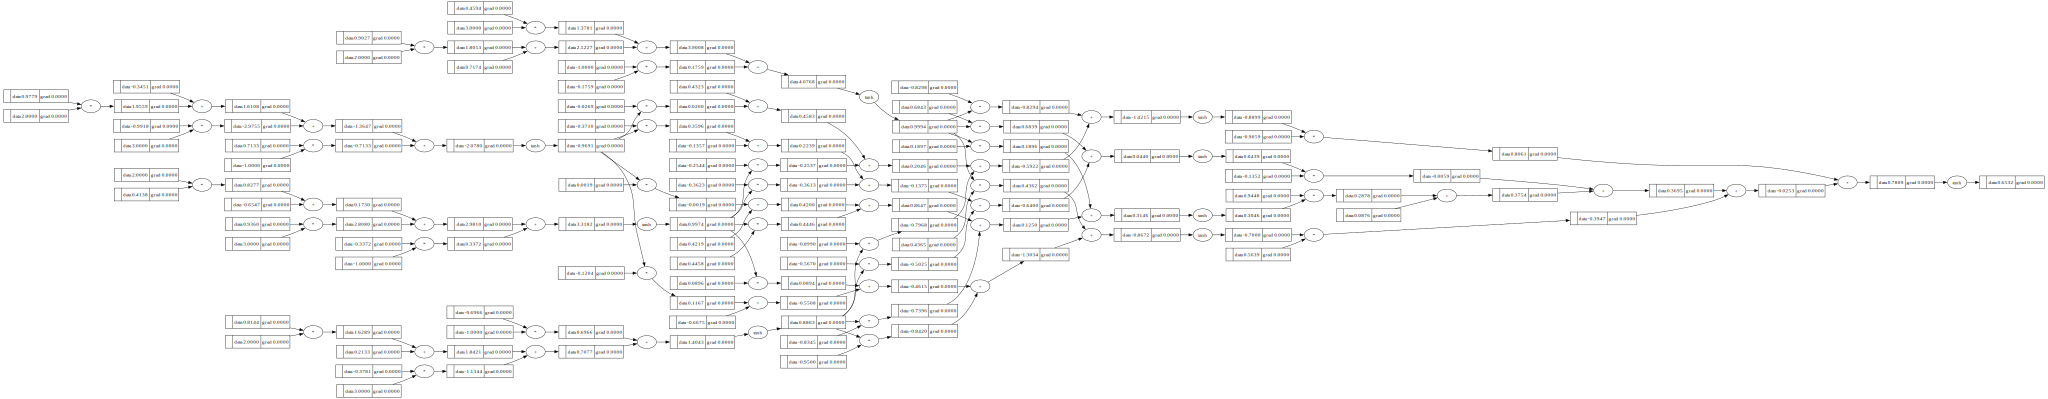

In [49]:
import random
class Neuron:
    def __init__(self, ninputs):
        self.w = [Value(random.uniform(-1,1)) for _ in range(ninputs)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # pairs = zip(self.w, x) # zip creates an iterator over two lists in parallel
        # print(list(pairs)) # converting to list exhausts the iterator, which drains the iterator hence comment out
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # create activation by summing w1*x1 + w2*x2 + ... + b aka forward pass
        out = act.tanh() # apply non-linear activation function
        return out # apply non-linear activation function

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] # create nout neurons each with nin inputs

    def __call__(self, x):
        outs = [n(x) for n in self.neurons] # set inputs

        return outs[0] if len(outs) == 1 else outs # return single value if only one neuron otherwise return list of outputs
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

n = Neuron(2)
x = [2.0, 3.0]
# n(x) # uses __call__
print(f'n: {n(x)}')

l = Layer(3, 3) # layer with 3 inputs and 3 neurons
x = [2.0, 3.0, -1.0]
#l(x) # uses __call__
print(f'l: {l(x)}')

mlp = MLP(3, [4,4,1]) # 3 inputs, 3 layers  l1 = 4 neurons, l2 = 4 neurons, l3 = 1 neuron

print(f'mlp: {mlp(x)}')


draw_dot(mlp(x))